# EveryBeam OSKAR SKA integration tests

These tests are all setup and explained in `test_OSKAR-MWA.ipynb`, so check that out first if you haven't already.

Goes without saying, but these tests rely on `everybeam` being installed.

In [6]:
from subprocess import call
from astropy.io import fits
import numpy as np
from astropy.table import Column, Table
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation
from astropy import units as u
import matplotlib.pyplot as plt
import numpy.testing as npt
from astropy.constants import c
from astropy.wcs import WCS
import everybeam as eb
from wodenpy.primary_beam.use_everybeam import load_OSKAR_telescope, load_LOFAR_telescope, get_everybeam_norm, run_everybeam, radec_to_xyz
import erfa
import mwa_hyperbeam

##A bunch of test and plotting code lives here so we can use it in multile notebooks
from eb_testing_code import create_WCS, plot_jones_on_sky, plot_everybeam_on_sky, make_sky_models, read_uvfits, convert_inst_to_stokes, test_stokes_recovery, getFDF, findpeaks, test_RM_recovery, make_RM_skymodel

from wodenpy.skymodel.read_fits_skymodel import calc_everybeam_for_components
from wodenpy.use_libwoden.create_woden_struct_classes import Woden_Struct_Classes
from ctypes import c_double
from astropy.time import TimeDelta
from wodenpy.use_libwoden.skymodel_structs import c_double_complex

from wodenpy.array_layout.create_array_layout import convert_ecef_to_enh
from casacore.tables import table

C = c.to('m/s').value

First up just quickly, let's see what station layout I'm using

Successful readonly open of default-locked table create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms/ANTENNA: 8 columns, 512 rows


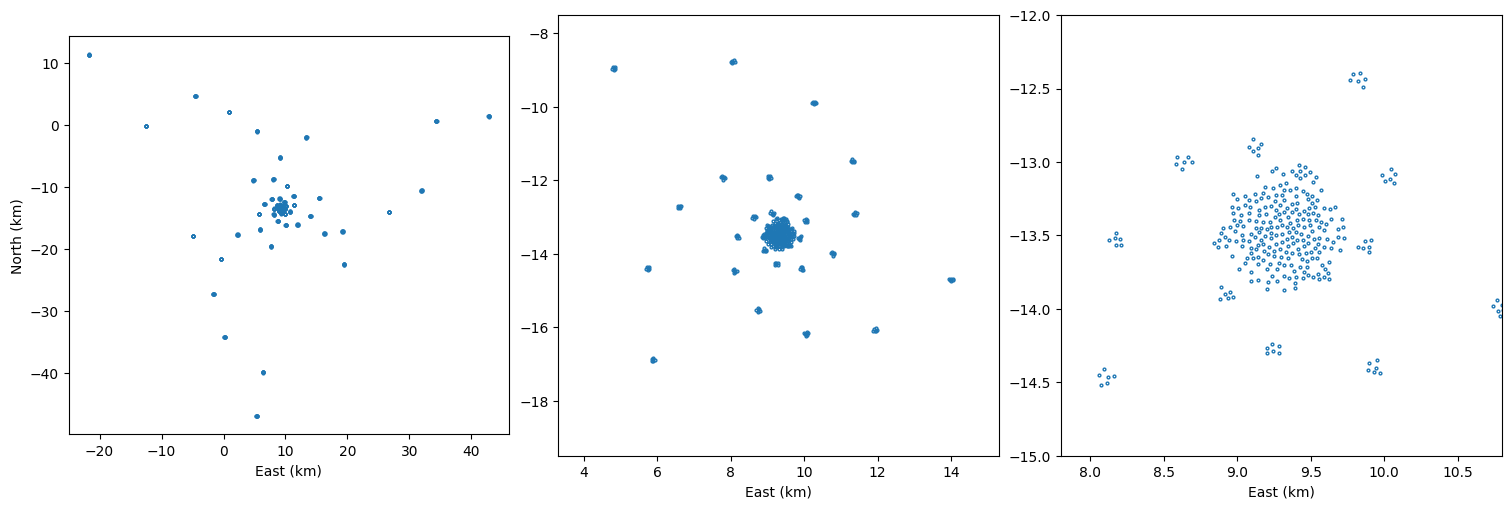

In [41]:
MWA_LAT=-26.703319405555554
long=116.67081523611111

with table('create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms' + '/ANTENNA') as t: 
        
            num_ants = len(t)
            ant_locations = np.array([t.getcell('POSITION', ant) for ant in range(num_ants)])
            ##convert from ECEF to ENH, as WODEN starts with enh coords
            east, north, height = convert_ecef_to_enh(ant_locations[:,0],
                                        ant_locations[:,1], ant_locations[:,2],
                                        np.radians(long),
                                        np.radians(MWA_LAT))

east /= 1000
north /= 1000

fig, axs = plt.subplots(1, 3, figsize=(15, 5), layout='constrained')

for ax in axs:
    ax.plot(east, north, 'o',mfc='none', ms=2)

edge = 6
x_cent = 9.3
y_cent = -13.5

axs[1].set_xlim(x_cent-edge, x_cent+edge)
axs[1].set_ylim(y_cent-edge, y_cent+edge)

edge = 1.5
axs[2].set_xlim(x_cent-edge, x_cent+edge)
axs[2].set_ylim(y_cent-edge, y_cent+edge)

for ax in axs:
    ax.set_xlabel('East (km)')
    ax.set_aspect('equal', 'box')
axs[0].set_ylabel('North (km)')
plt.show()


### Image the beam on the sky

First up, let's see if we can just plot an OSKAR SKA station beam to check it looks sensible.

In [2]:
ra0 = 0.0
dec0 = -26.7


##pick a time/date that sticks our phase centre overhead
date = "2024-07-21T20:13:00"
##Assume that the OSKAR telescope is near the MWA??
mwa_location = EarthLocation(lat=MWA_LAT*u.deg, 
                            lon=long*u.deg,
                            height=377.827)
observing_time = Time(date, scale='utc', location=mwa_location)

##Grab the LST
LST = observing_time.sidereal_time('mean')
LST_deg = LST.value*15
print(f"LST: {LST_deg} deg, RA: {ra0}")

LST: 0.00455202630786671 deg, RA: 0.0


OSKAR response model skala40_wave
Could not load dataset for frequency 100 MHz, using the nearest neighbor with frequency 110 MHz instead


/home/jack-line/software/anaconda3/envs/everybeam/lib/python3.12/site-packages/erfa/core.py:4620: RuntimeWarning: invalid value encountered in ld
  p1 = ufunc.ld(bm, p, q, e, em, dlim)
/home/jack-line/software/anaconda3/envs/everybeam/lib/python3.12/site-packages/erfa/core.py:19004: RuntimeWarning: invalid value encountered in anp
  c_retval = ufunc.anp(a)
2024-09-04 02:11:15	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)	Leap second table TAI_UTC seems out-of-date.
2024-09-04 02:11:15	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	Until the table is updated (see the CASA documentation or your system admin),
2024-09-04 02:11:15	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	times and coordinates derived from UTC could be wrong by 1s or more.
2024-09-04 02:11:15	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)	Requested data table IERSeop97 cannot be found in

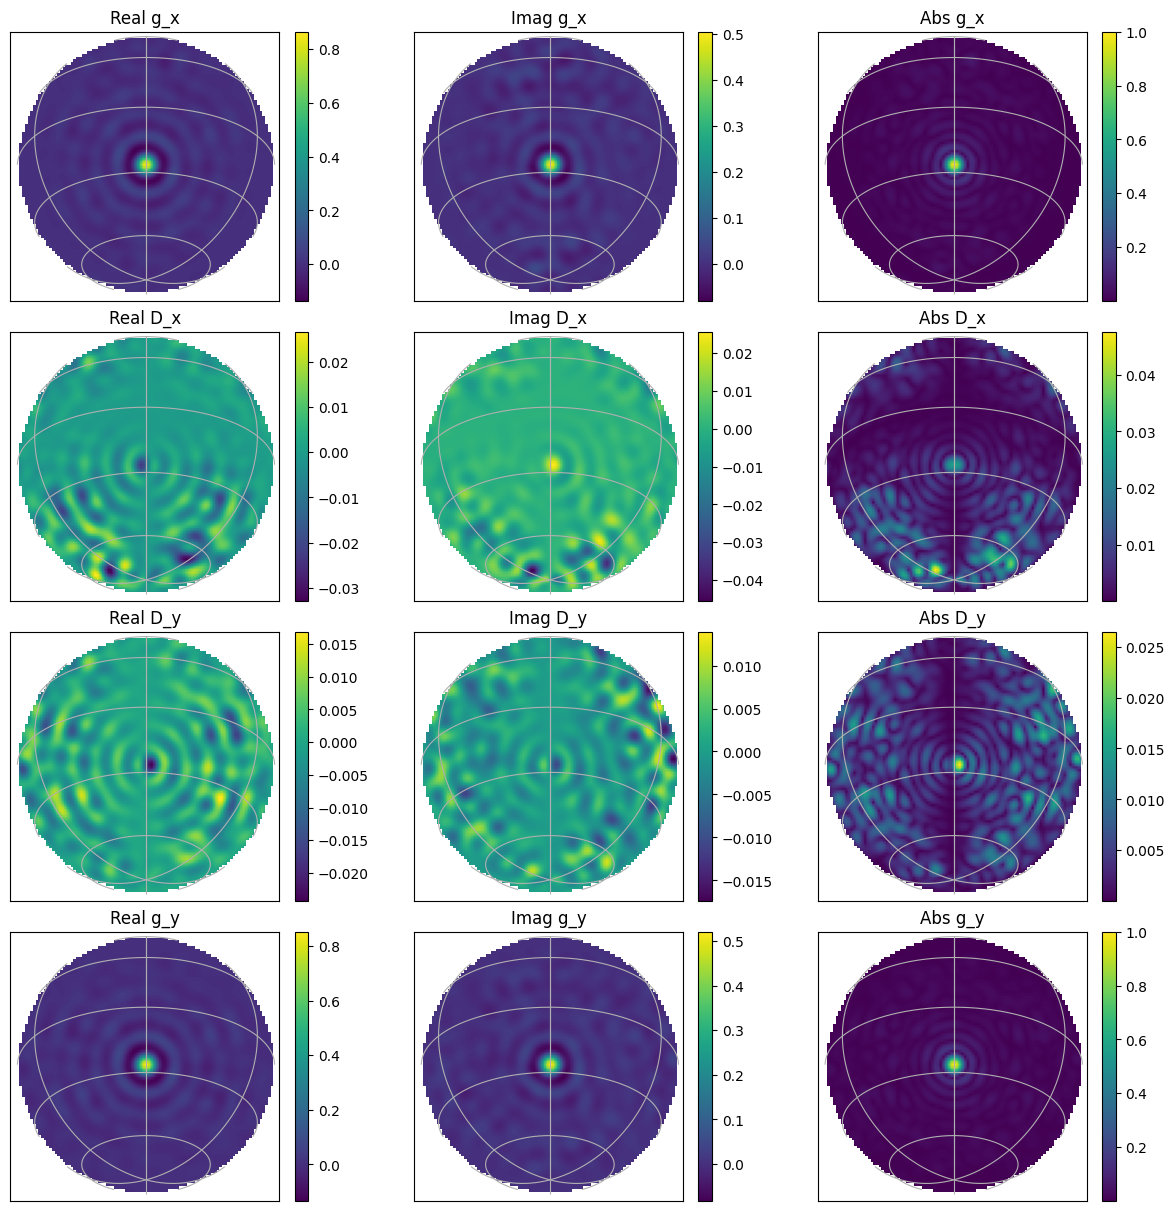

In [3]:
ms_path="create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms"

# Load the telescope
telescope = load_OSKAR_telescope(ms_path)

freq = 100e+6
station_id = 0

_ = plot_everybeam_on_sky(ra0, dec0, observing_time, freq, station_id, telescope)

## Stokes recovery
Now try to recover single point source of either Stokes I, Q, U or V.

In [4]:
make_sky_models(ra0, dec0)

freq_reso = 1e+6
# low_freq = 180e+6
# high_freq = 210e+6
low_freq = 100e+6
high_freq = 150e+6


num_freq_chans = int((high_freq - low_freq) / freq_reso)

primary_beam = "everybeam_OSKAR"

for pol in ['I', 'Q', 'U', 'V']:
# for pol in ['I']:

    uvfits_name = f"stokes{pol}_{primary_beam}"
    cat_name = f'{pol}_source.fits'
    
    ##The command to run WODEN
    command = f'run_woden.py --ra0={ra0} --dec0={dec0} '
    command += f'--latitude={MWA_LAT} --longitude={long} '
    command += f'--date={date} --output_uvfits_prepend={uvfits_name} '
    command += f'--cat_filename={cat_name} --primary_beam={primary_beam} '
    command += f'--lowest_channel_freq={low_freq} --freq_res={freq_reso} '
    command += f'--num_freq_channels={num_freq_chans} --band_nums=1 '
    command += f'--time_res=2 --num_time_steps=1 --IAU_order '
    command += f' --station_id=0 '
    command += f'--beam_ms_path=create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms'
    
    call(command, shell=True)

Successful readonly open of default-locked table create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms/ANTENNA: 8 columns, 512 rows
You are using WODEN commit: 336d807
LOADING IN /home/jack-line/software/anaconda3/envs/everybeam/lib/python3.12/site-packages/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 0.00000deg -26.70000deg
Obs epoch initial LST was 0.0087301096 deg
Setting initial J2000 LST to 359.6931723781 deg
Setting initial mjd to 60512.8423726853
After precession initial latitude of the array is -26.8398178265 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1 components
After cropping there are 1 components
After chunking there are 1 chunks
Reading chunks skymodel chunks 0:50
OSKAR response model skala40_wave


2024-09-04 02:11:26	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)	Leap second table TAI_UTC seems out-of-date.
2024-09-04 02:11:26	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	Until the table is updated (see the CASA documentation or your system admin),
2024-09-04 02:11:26	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	times and coordinates derived from UTC could be wrong by 1s or more.
2024-09-04 02:11:26	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)	Requested data table IERSeop97 cannot be found in the searched directories:
2024-09-04 02:11:26	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/ephemerides/
2024-09-04 02:11:26	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/geodetic/
2024-09-04 02:11:26	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS

Could not load dataset for frequency 100 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 101 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 102 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 103 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 104 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 105 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 106 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 107 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 108 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 109 MHz, using the nearest 

2024-09-04 02:11:32	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)	Leap second table TAI_UTC seems out-of-date.
2024-09-04 02:11:32	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	Until the table is updated (see the CASA documentation or your system admin),
2024-09-04 02:11:32	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	times and coordinates derived from UTC could be wrong by 1s or more.
2024-09-04 02:11:32	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)	Requested data table IERSeop97 cannot be found in the searched directories:
2024-09-04 02:11:32	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/ephemerides/
2024-09-04 02:11:32	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/geodetic/
2024-09-04 02:11:32	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS

Could not load dataset for frequency 100 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 101 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 102 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 103 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 104 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 105 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 106 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 107 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 108 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 109 MHz, using the nearest 

2024-09-04 02:11:39	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)	Leap second table TAI_UTC seems out-of-date.
2024-09-04 02:11:39	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	Until the table is updated (see the CASA documentation or your system admin),
2024-09-04 02:11:39	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	times and coordinates derived from UTC could be wrong by 1s or more.
2024-09-04 02:11:39	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)	Requested data table IERSeop97 cannot be found in the searched directories:
2024-09-04 02:11:39	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/ephemerides/
2024-09-04 02:11:39	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/geodetic/
2024-09-04 02:11:39	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS

Could not load dataset for frequency 100 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 101 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 102 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 103 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 104 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 105 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 106 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 107 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 108 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 109 MHz, using the nearest 

2024-09-04 02:11:45	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)	Leap second table TAI_UTC seems out-of-date.
2024-09-04 02:11:45	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	Until the table is updated (see the CASA documentation or your system admin),
2024-09-04 02:11:45	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	times and coordinates derived from UTC could be wrong by 1s or more.
2024-09-04 02:11:45	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)	Requested data table IERSeop97 cannot be found in the searched directories:
2024-09-04 02:11:45	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/ephemerides/
2024-09-04 02:11:45	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/geodetic/
2024-09-04 02:11:45	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS

Could not load dataset for frequency 100 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 101 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 102 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 103 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 104 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 105 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 106 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 107 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 108 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 109 MHz, using the nearest 

In [5]:
for pol in ['I', 'Q', 'U', 'V']:
    uvfits_name = f"stokes{pol}_everybeam_OSKAR"
    XX, XY, YX, YY = read_uvfits(f'{uvfits_name}_band01.uvfits')
    ##pick a random baseline to plot, they should all be the sam
    baseline = 0

    recover_I, recover_Q, recover_U, recover_V = convert_inst_to_stokes(XX[baseline], XY[baseline], YX[baseline], YY[baseline])
    
    print(f"Input {pol}, Recover I {recover_I[0].real:.2f}, Q {recover_Q[0].real:.2f}, U {recover_U[0].real:.2f}, V {recover_V[0].real:.2f}")
    print(f"Input {pol}, Recover I {recover_I[-1].real:.2f}, Q {recover_Q[-1].real:.2f}, U {recover_U[-1].real:.2f}, V {recover_V[-1].real:.2f}")
    
    test_stokes_recovery(pol, 'everybeam_OSKAR', atol=9e-2)

Input I, Recover I 1.00, Q 0.00, U -0.01, V 0.02
Input I, Recover I 1.00, Q 0.00, U -0.04, V -0.04
Testing Stokes I
Stokes I passed
Input Q, Recover I -0.00, Q 1.00, U -0.02, V -0.03
Input Q, Recover I -0.00, Q 1.00, U 0.08, V -0.06
Testing Stokes Q
Stokes Q passed
Input U, Recover I -0.01, Q 0.01, U 1.00, V -0.02
Input U, Recover I -0.04, Q -0.08, U 1.00, V -0.02
Testing Stokes U
Stokes U passed
Input V, Recover I 0.02, Q 0.03, U 0.02, V 1.00
Input V, Recover I -0.04, Q 0.05, U 0.02, V 1.00
Testing Stokes V
Stokes V passed


We get back what we put in so all is well.

## RM recovery

In [6]:
phi_RM, pol_frac = make_RM_skymodel(ra0, dec0)

freq_reso = 0.1e+6
low_freq = 100e+6
high_freq = 130e+6
num_freq_chans = int((high_freq - low_freq) / freq_reso)


primary_beam = "everybeam_OSKAR"

uvfits_name = f"rm_source_{primary_beam}"
cat_name = 'RM_source.fits'

##The command to run WODEN
command = f'run_woden.py --ra0={ra0} --dec0={dec0} '
command += f'--date={date} --output_uvfits_prepend={uvfits_name} '
command += f'--latitude={MWA_LAT} --longitude={long} '
command += f'--cat_filename={cat_name} --primary_beam={primary_beam} '
command += f'--lowest_channel_freq={low_freq} --freq_res={freq_reso} '
command += f'--num_freq_channels={num_freq_chans} --band_nums=1 '
command += f'--time_res=2 --num_time_steps=1 --IAU_order '
command += f' --station_id=0 '
command += f'--beam_ms_path=create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms'

call(command, shell=True)

Successful readonly open of default-locked table create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms/ANTENNA: 8 columns, 512 rows
You are using WODEN commit: 336d807
LOADING IN /home/jack-line/software/anaconda3/envs/everybeam/lib/python3.12/site-packages/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 0.00000deg -26.70000deg
Obs epoch initial LST was 0.0087301096 deg
Setting initial J2000 LST to 359.6931723781 deg
Setting initial mjd to 60512.8423726853
After precession initial latitude of the array is -26.8398178265 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1 components
After cropping there are 1 components
After chunking there are 1 chunks
Reading chunks skymodel chunks 0:50
OSKAR response model skala40_wave


2024-09-04 02:11:55	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)	Leap second table TAI_UTC seems out-of-date.
2024-09-04 02:11:55	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	Until the table is updated (see the CASA documentation or your system admin),
2024-09-04 02:11:55	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	times and coordinates derived from UTC could be wrong by 1s or more.
2024-09-04 02:11:55	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)	Requested data table IERSeop97 cannot be found in the searched directories:
2024-09-04 02:11:55	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/ephemerides/
2024-09-04 02:11:55	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/geodetic/
2024-09-04 02:11:55	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS

Could not load dataset for frequency 100 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 100 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 100 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 100 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 100 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 100 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 100 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 100 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 100 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 100 MHz, using the nearest 

0

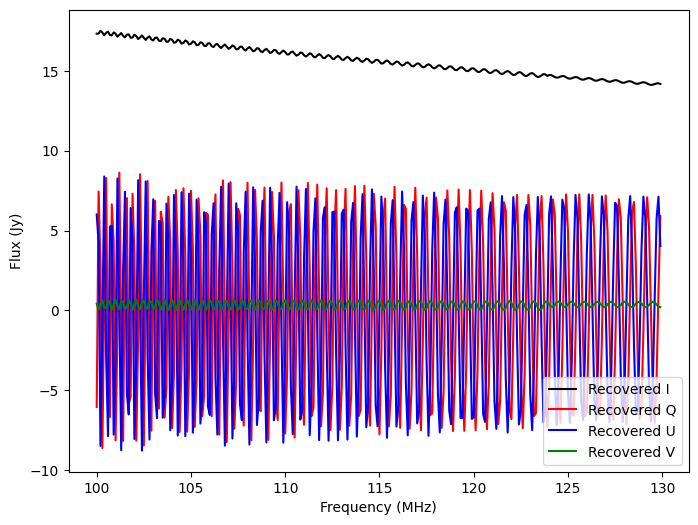

In [7]:
XX, XY, YX, YY = read_uvfits('rm_source_everybeam_OSKAR_band01.uvfits')
baseline = 0    
recover_I, recover_Q, recover_U, recover_V = convert_inst_to_stokes(XX[baseline], XY[baseline], YX[baseline], YY[baseline])

    
freqs = np.arange(low_freq, high_freq, freq_reso)

fig, axs = plt.subplots(1, 1, figsize=(8, 6))

axs.plot(freqs / 1e+6, recover_I.real, 'k-', label='Recovered I')
axs.plot(freqs / 1e+6, recover_Q.real, 'r', label='Recovered Q')
axs.plot(freqs / 1e+6, recover_U.real, 'b', label='Recovered U')
axs.plot(freqs / 1e+6, recover_V.real, 'g', label='Recovered V')

axs.legend()

axs.set_xlabel('Frequency (MHz)')
axs.set_ylabel('Flux (Jy)')

plt.show()

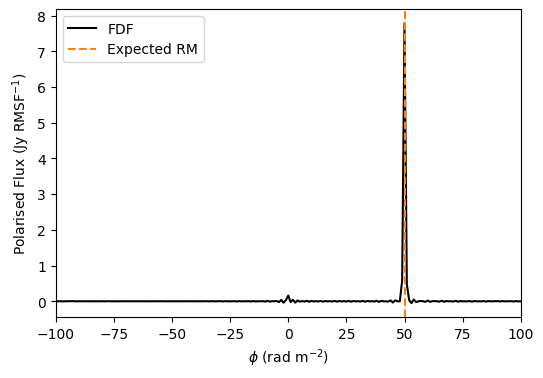

Recovered RM: 50.0 Expected RM: 50
Recovered Pol. Fraction: 0.49983016 Expected Pol Fraction 0.5


In [8]:
test_RM_recovery(uvfits_name, phi_RM, pol_frac, freqs, atol=0.02)

We recover the correct RM which is nice.

## Test unique primary beam per station

First up, we'll call the `calc_everybeam_for_components` function, which is what `wodenpy` uses to calculate an `everybeam`. We'll unpack the outputs and plot on the sky to see if each station has a unique beam. This will take a little faffing, as `wodenpy` writes this information directly into the `Component` ctypes pbject, so we'll need to do some mallocing and copying to get it out.

After we'll run a full `WODEN` simulation with an off-zenith point source to check that all visibilities are unique. 

In [9]:
##Setup a grid of RA/Dec on the sky
nside=50
radec_reso = 60/nside

header, wcs = create_WCS(ra0, dec0, nside, radec_reso)
x_mesh, y_mesh = np.meshgrid(np.arange(nside), np.arange(nside))
ras, decs = wcs.all_pix2world(x_mesh, y_mesh, 0)

ras = np.radians(ras.flatten())
decs = np.radians(decs.flatten())

num_comps = len(ras)

##Create a woden struct class with double precision for the components
struct_classes = Woden_Struct_Classes(precision='double')

##Create the components struct
components = struct_classes.Components()
##Allocate memory for the coords
components.ras = (c_double*num_comps)()
components.decs = (c_double*num_comps)()

##populate the coords
for ind, ra, dec in zip(range(num_comps), ras, decs):
    components.ras[ind] = ra
    components.decs[ind] = dec

# # Load the telescope
telescope = load_OSKAR_telescope("create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms")
num_beams = telescope.nr_stations

##Do a couple of frequencies to check mapping is working
all_freqs = np.array([50e+6, 100e+6])

##Do two times, 3 hours apart to check things move on the sky
all_times = np.array([observing_time, observing_time + TimeDelta(3*3600, format='sec')])

##allocate memory for the beam values

num_freqs = len(all_freqs)
num_times = len(all_times)

complex_num_beams = c_double_complex*(num_comps*num_beams*num_freqs*num_times)
        
components.gxs = complex_num_beams()
components.Dxs = complex_num_beams()
components.Dys = complex_num_beams()
components.gys = complex_num_beams()


calc_everybeam_for_components(np.radians(ra0), np.radians(dec0),
                              num_comps, components, telescope,
                              all_times, all_freqs)


##just look at the outputs for the gx values, tells us if things are changing




OSKAR response model skala40_wave


In [10]:
##grab the outputs, which should be ordered as primary beam slowest changing, time, freq, componnent fastest changing
##Do it over loops so we can get the real/imag parts out of the c_double_complex struct

recover_gx = np.zeros((num_beams, num_times, num_freqs, num_comps), dtype=np.complex128)

for beam_ind in range(num_beams):
    for time_ind, time in enumerate(all_times):
        for freq_ind, freq in enumerate(all_freqs):
            for comp_ind in range(num_comps):
                recover_gx[beam_ind, time_ind, freq_ind, comp_ind] = components.gxs[beam_ind*num_comps*num_freqs*num_times + time_ind*num_comps*num_freqs + freq_ind*num_comps + comp_ind].real + 1j*components.gxs[beam_ind*num_comps*num_freqs*num_times + time_ind*num_comps*num_freqs + freq_ind*num_comps + comp_ind].imag

512


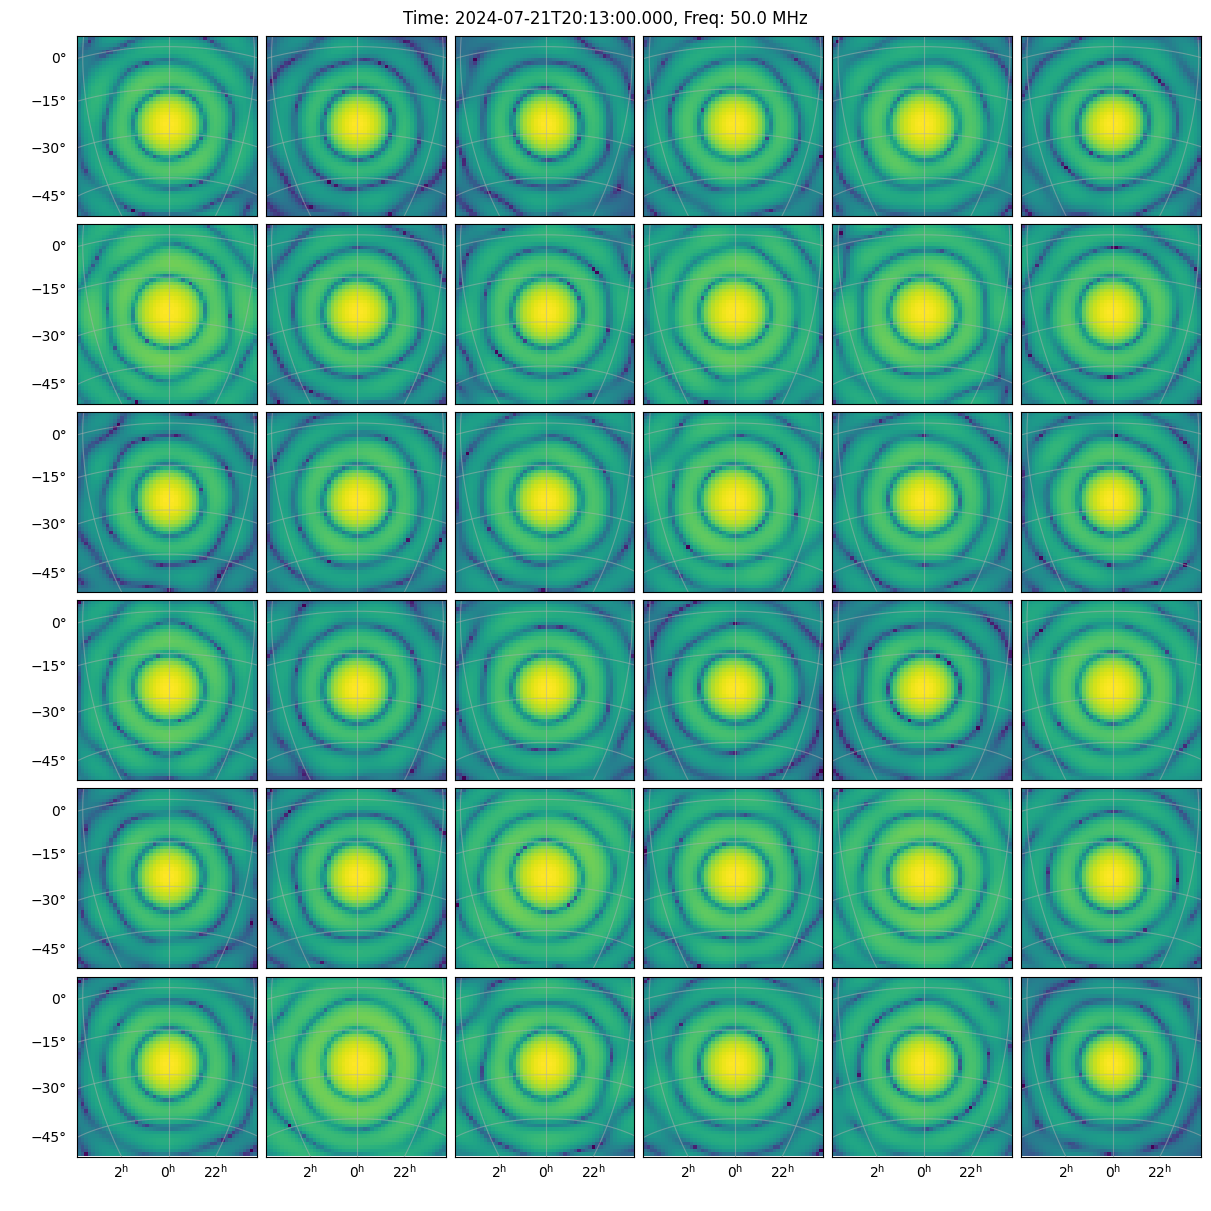

In [11]:
print(telescope.nr_stations)

def plot_beam_selection(recover_gx, time_ind, freq_ind, nside, wcs):
    fig, axs = plt.subplots(6, 6, figsize=(12, 12), layout='constrained',
                            subplot_kw={'projection': wcs})
    
    for col in range(6):
        for row in range(6):
            beam_ind = col*6 + row
            
            gx = recover_gx[beam_ind, time_ind, freq_ind, :]
            gx.shape = (nside, nside)
            
            axs[row, col].imshow(np.log10(np.abs(gx)), origin='lower')
            
            axs[row, col].grid(alpha=0.5)
            
            # axs[row, col].set_ylabel('')
            
            lon = axs[row, col].coords[0]
            lat = axs[row, col].coords[1]
            
            lon.set_ticks_visible(False)
            lat.set_ticks_visible(False)
            lon.set_axislabel(' ')
            lat.set_axislabel(' ')
            
            
            if col > 0:
                lat.set_ticklabel_visible(False)
            if row < 5:
                lon.set_ticklabel_visible(False)
            

    fig.suptitle(f"Time: {all_times[time_ind].isot}, Freq: {all_freqs[freq_ind]/1e+6} MHz")

    plt.show()
    
plot_beam_selection(recover_gx, 0, 0, nside, wcs)

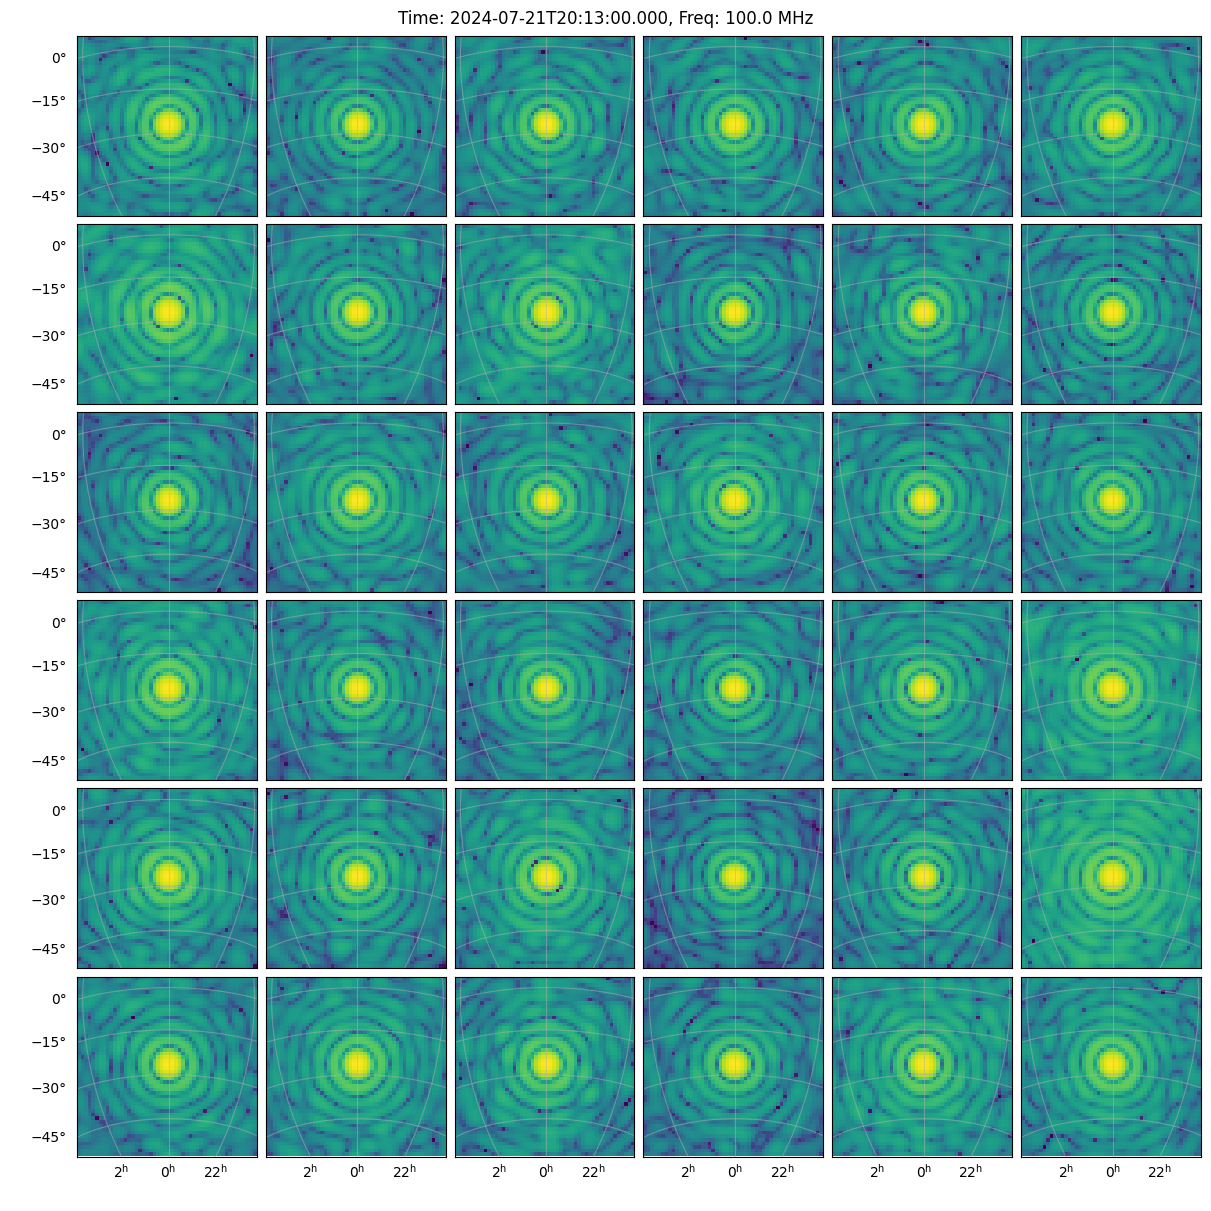

In [12]:
plot_beam_selection(recover_gx, 0, 1, nside, wcs)

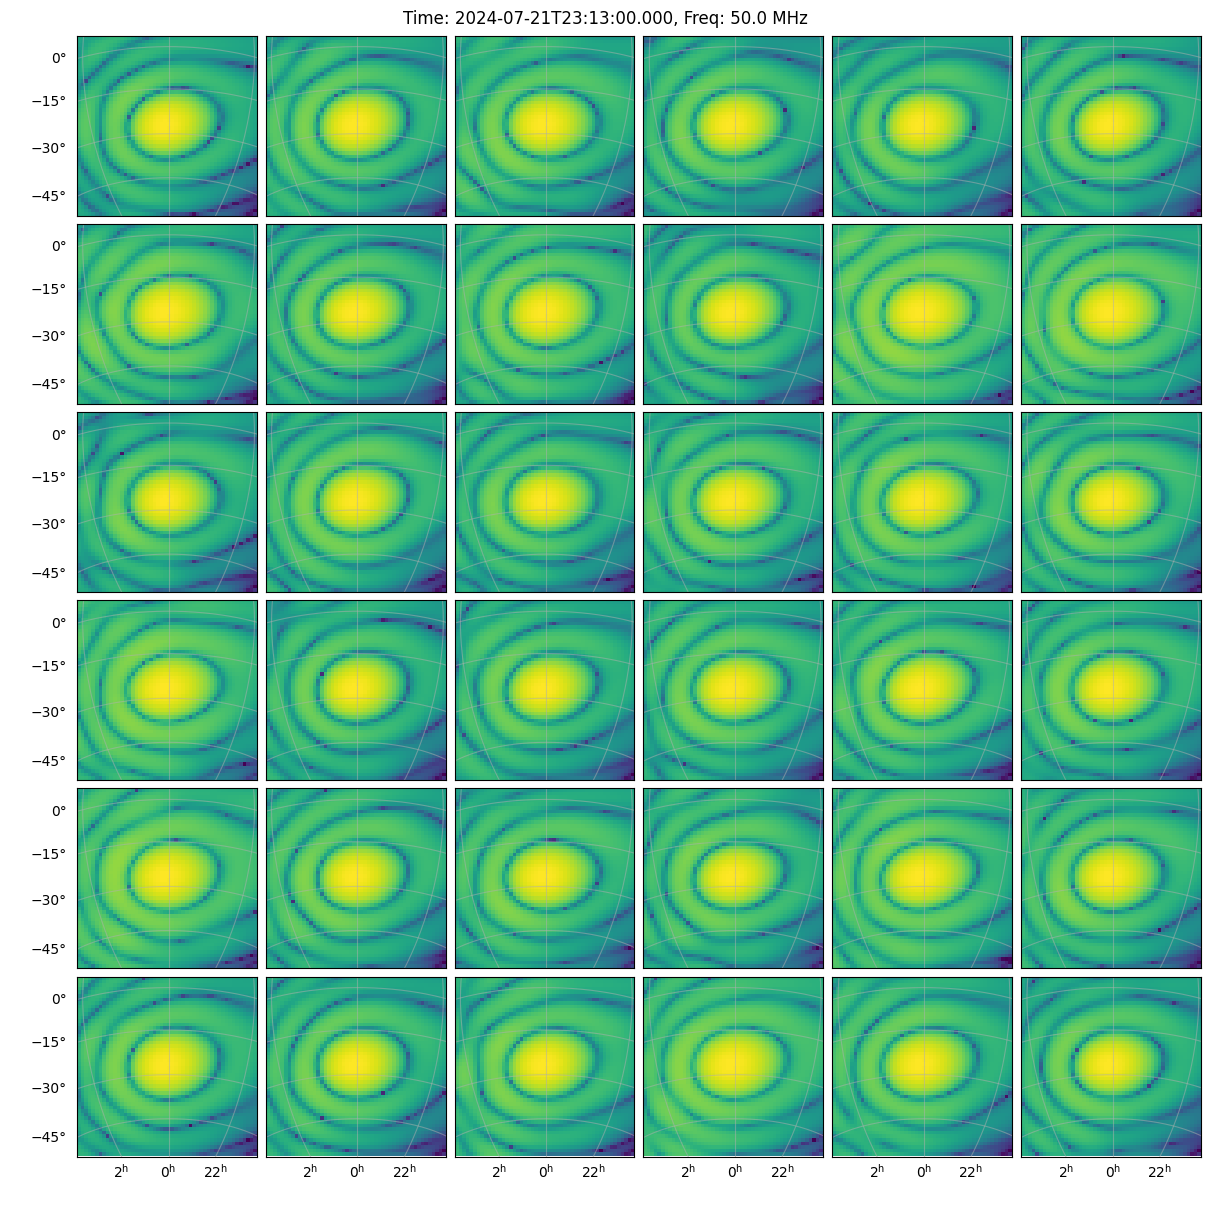

In [13]:
plot_beam_selection(recover_gx, 1, 0, nside, wcs)

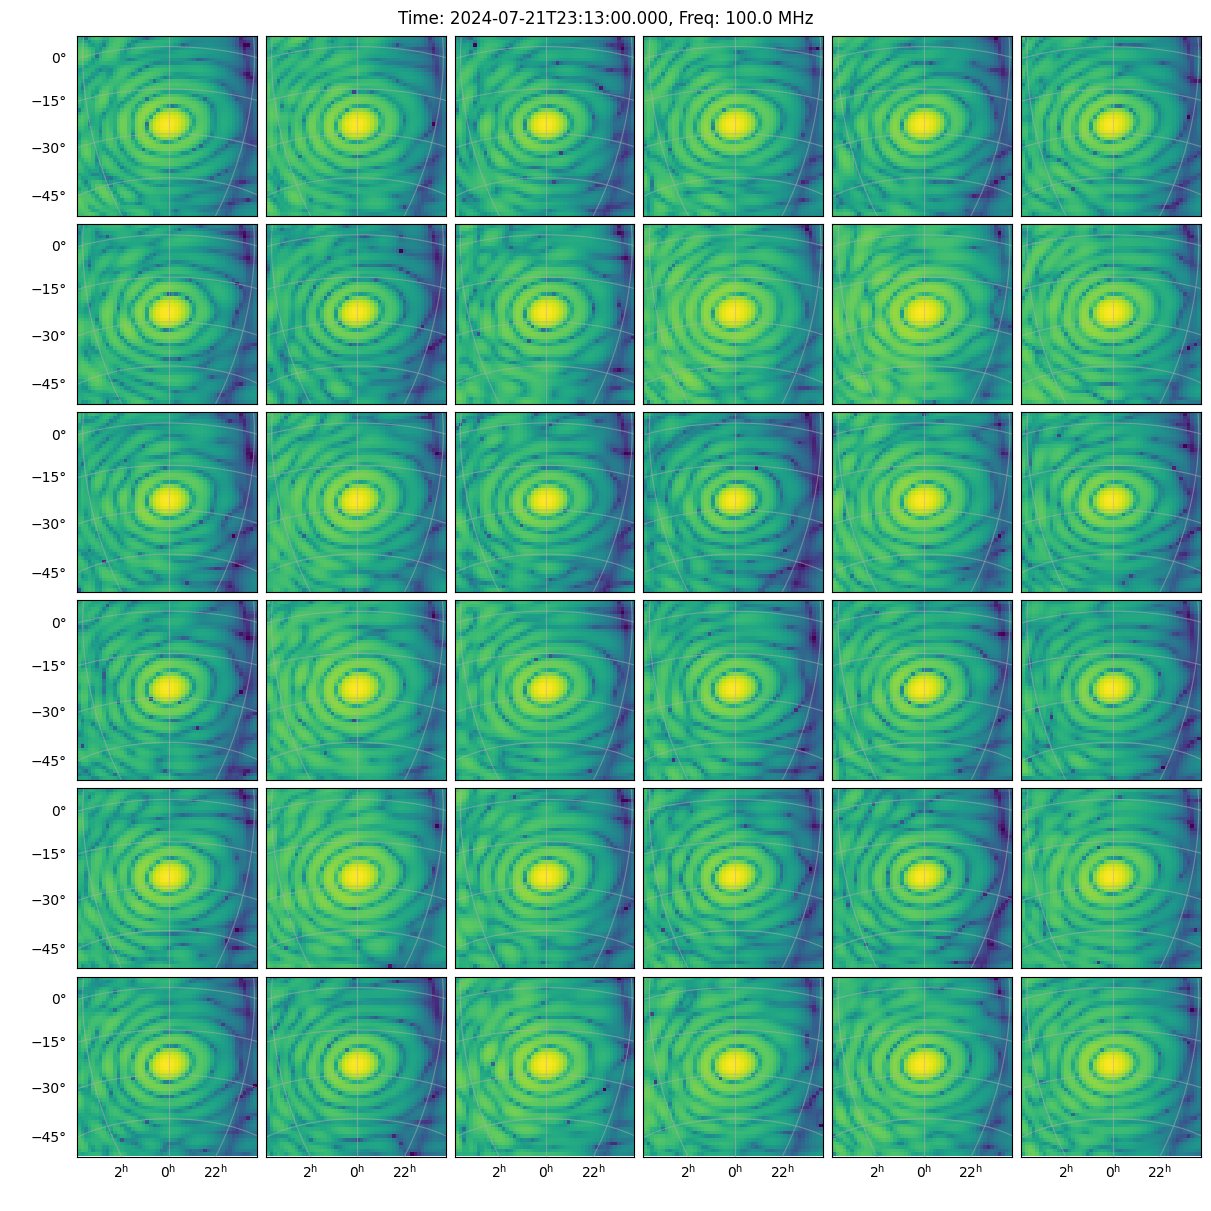

In [14]:
plot_beam_selection(recover_gx, 1, 1, nside, wcs)

OK, so 3.6s to calculate the LOFAR Harmaker beam for a single station (but for the whole observation)

## Let's make an image

In [15]:
ra_coord_hw = 15
dec_coord_hw = 10

num_coords = 500

ras = np.random.uniform(ra0 - ra_coord_hw, ra0 + ra_coord_hw, num_coords)
decs = np.random.uniform(dec0 - dec_coord_hw, dec0 + dec_coord_hw, num_coords)

ras[ras < 0] += 360

num_comps = len(ras)

c_ids = Column(data=np.array(['source']*num_comps), name='UNQ_SOURCE_ID', dtype='|S20')
c_names = Column(data=np.array([f'source_C{i:04d}' for i in range(num_comps)]), name='NAME', dtype='|S20')

##Component position
c_ras = Column(data=ras, name='RA')
c_decs = Column(data=decs, name='DEC')

##This says we have a point source
c_comp_types = Column(data=np.array(['P']*num_comps, dtype='|S1'), name="COMP_TYPE", dtype='|S1')
##This says we have a Stokes I power-law SED
c_mod_types = Column(data=np.array(['pl']*num_comps, dtype='|S3'), name="MOD_TYPE", dtype='|S3')

##Set everything as a flat spectrum 1 Jy stokes I source. That way we can image it and see the beam pattern
c_stokes_I_ref = Column(data=np.random.uniform(1, 10, num_comps), name='NORM_COMP_PL')
c_stokes_I_SI = Column(data=np.zeros(num_comps), name='ALPHA_PL')


cols = [c_ids, c_names, c_ras, c_decs, c_comp_types, c_mod_types, c_stokes_I_ref, c_stokes_I_SI]

main_table = Table(cols)

profile_cat = 'profiling_source.fits'

main_table.write(profile_cat, format='fits', overwrite=True)

In [16]:
cat_name = "profiling_source.fits"
low_freq = 50e+6
freq_reso = 100e+3
num_freq_chans = 1
uvfits_name = 'ska_image_test'
primary_beam = 'everybeam_OSKAR'

##The command to run WODEN
command = f'run_woden.py --ra0={ra0} --dec0={dec0} '
command += f'--latitude={MWA_LAT} --longitude={long} '
command += f'--date={date} --output_uvfits_prepend={uvfits_name} '
command += f'--cat_filename={cat_name} --primary_beam={primary_beam} '
command += f'--lowest_channel_freq={low_freq} --freq_res={freq_reso} '
command += f'--num_freq_channels={num_freq_chans} --band_nums=1 '
command += f'--time_res=2 --num_time_steps=2 --IAU_order '
# command += f' --station_id=0 '
command += f'--beam_ms_path=create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms'

call(command, shell=True)

Successful readonly open of default-locked table create_OSKAR-SKA_ms/OSKAR-SKA-layout.ms/ANTENNA: 8 columns, 512 rows
You are using WODEN commit: 336d807
LOADING IN /home/jack-line/software/anaconda3/envs/everybeam/lib/python3.12/site-packages/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 0.00000deg -26.70000deg
Obs epoch initial LST was 0.0087301096 deg
Setting initial J2000 LST to 359.6931723781 deg
Setting initial mjd to 60512.8423726853
After precession initial latitude of the array is -26.8398178265 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 500 components
After cropping there are 500 components
After chunking there are 1 chunks
Reading chunks skymodel chunks 0:50
OSKAR response model skala40_wave


2024-09-04 02:33:37	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)	Leap second table TAI_UTC seems out-of-date.
2024-09-04 02:33:37	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	Until the table is updated (see the CASA documentation or your system admin),
2024-09-04 02:33:37	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	times and coordinates derived from UTC could be wrong by 1s or more.
2024-09-04 02:33:37	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)	Requested data table IERSeop97 cannot be found in the searched directories:
2024-09-04 02:33:37	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/ephemerides/
2024-09-04 02:33:37	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/geodetic/
2024-09-04 02:33:37	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS

Reading chunks 0:50 took 0.8 mins
WODEN is using DOUBLE precision
Simulating band 01 with bottom freq 5.00000000e+07
About to copy the chunked source to the GPU
Have copied across the chunk to the GPU
Processing chunk 0
	Number of components in chunk are: P 500 G 0 S_coeffs 0
	Doing point components
	Extrapolating fluxes and beams...
	Extrapolating fluxes and beams done.
	Doing visi kernel...
	Visi kernel done
GPU calls for band 1 finished


0

In [17]:
cmd = "woden_uv2ms.py "
cmd += "  --uvfits_prepend=ska_image_test_band "
cmd += "  --band_nums=1  "

call(cmd, shell=True)

cmd = "wsclean -name ska_image_test -size 4096 4096 -niter 2000 "
cmd += "  -auto-threshold 0.5 -auto-mask 3 "
cmd += "  -pol I -multiscale -weight briggs 0 -scale 0.005 -j 12 -mgain 0.85 "
cmd += "  -no-update-model-required "
cmd += "  ska_image_test_band*.ms "

call(cmd, shell=True)

The telescope frame is set to '????', which generally indicates ignorance. Defaulting the frame to 'itrs', but this may lead to other warnings or errors.
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 4.737322298204845 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 4.737322298204845 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.
Writing in the MS file that the units of the data are uncalib, although some CASA process will ignore this and assume the units are all in Jy (or may not know how to handle data in these units).



WSClean version 3.4 (2023-10-11)
This software package is released under the GPL version 3.
Author: André Offringa (offringa@gmail.com).

No corrected data in first measurement set: tasks will be applied on the data column.
=== IMAGING TABLE ===
       # Pol Ch JG ²G FG FI In Freq(MHz)
| Independent group:
+-+-J- 0  I   0  0  0  0  0  0  50-50 (1)
Reordering ska_image_test_band01.ms into 1 x 1 parts.
Reordering: 0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%
Initializing model visibilities: 0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%
 == Constructing PSF ==
Precalculating weights for Briggs'(0) weighting...
Opening reordered part 0 spw 0 for ska_image_test_band01.ms
Detected 62.7 GB of system memory, usage not limited.
Opening reordered part 0 spw 0 for ska_image_test_band01.ms
Determining min and max w & theoretical beam size... DONE (w=[1.88873e-07:47.9305] lambdas, maxuvw=7253.73 lambda)
Theoretic beam = 28.44''
Small inversi

0

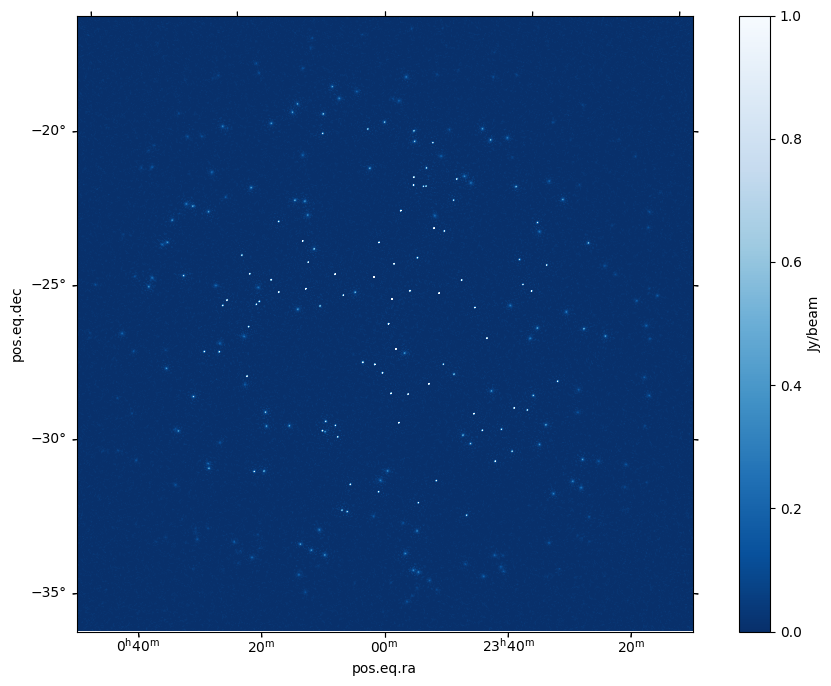

In [18]:
with fits.open('ska_image_test-image.fits') as hdu:
    image = np.squeeze(hdu[0].data)
    wcs = WCS(hdu[0].header).celestial
    
fig, axs = plt.subplots(1, 1, figsize=(12, 8), subplot_kw={'projection': wcs})

im = axs.imshow(image, origin='lower', cmap='Blues_r', vmin=0, vmax=1.0)
plt.colorbar(im, ax=axs, label='Jy/beam')

half_width = 2000
mid = 2048

axs.set_xlim(mid-half_width, mid+half_width)
axs.set_ylim(mid-half_width, mid+half_width)

plt.show()

What does the PSF look like?

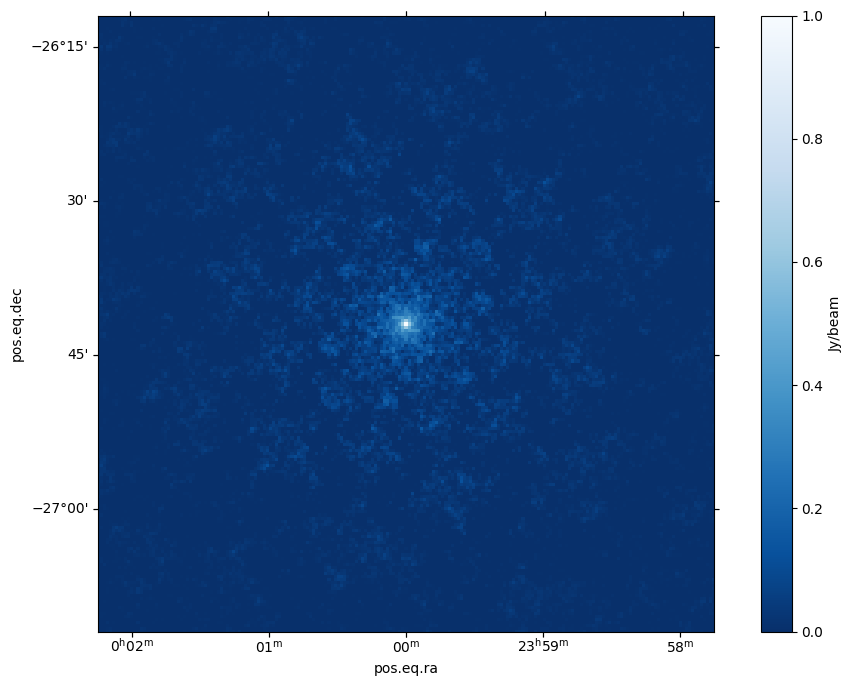

In [4]:
with fits.open('ska_image_test-psf.fits') as hdu:
    image = np.squeeze(hdu[0].data)
    wcs = WCS(hdu[0].header).celestial
    
fig, axs = plt.subplots(1, 1, figsize=(12, 8), subplot_kw={'projection': wcs})

im = axs.imshow(image, origin='lower', cmap='Blues_r', vmin=0, vmax=1.0)
plt.colorbar(im, ax=axs, label='Jy/beam')

half_width = 100
mid = 2048

axs.set_xlim(mid-half_width, mid+half_width)
axs.set_ylim(mid-half_width, mid+half_width)

plt.show()